# Generalized Bounding Box Approach

This notebook contains some preliminary experiments to design the generalized bounding box approach, which is implemented according to the procedures described in [Ghodgaonkar, et al. (2020)](https://arxiv.org/pdf/2008.12363.pdf).

In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import bounding_box as box

## Simulate Data

First, we simulate some data. We assume that we are given the bounding box coordinates (in implementation, this would be the output from a person-detection algorithm), and so we simulate data as colored boxed on a black background and return the bounding box coordinates of each box.

In [2]:
def simulate_data(dim, n_samples):
    """ Creates n simulated bounding boxes of a random color on a black grid of size dim.
        Returns the list of bounding box coordinates and the image of the data.
        Inputs:
            dim - dimension at which data is to be simulated, as [cols, rows].
            n_samples - number of bounding boxes to generate on the grid.
        Returns:
            box_list - list of bounding box coordinates, where each entry in the list is
                a set of bounding box coordinates, given as an ndarray in the form 
                [y1, x1, y2, x2].
            img - image of simulated data.
    """
    # get dimensions
    cols, rows = dim
    # create list for storing data [for image display]
    box_list = []
    for n in range(n_samples):
        # create rectangle at random location
        x1 = np.random.randint(cols)
        y1 = np.random.randint(rows)
        height = np.random.randint(48,72) # get height between 4 and 6 feet (1 in = 1 px)
        x2 = x1 + np.random.randint(12,height)
        y2 = y1 + height
        # record keypoints in list
        box_list.append([y1,x1,y2,x2])
    # show image
    img = np.zeros((rows,cols,3), np.uint8)
    # for all sets of original points
    for idx, pts in enumerate(box_list):
        # draw rectangle of random color at selected location
        color = (np.random.randint(256),np.random.randint(256),np.random.randint(256))
        cv2.rectangle(img,(pts[1],pts[0]),(pts[3],pts[2]),color,3)
    # show image
    plt.figure()
    plt.imshow(img)
    plt.show()
    # return list of points and image data
    return box_list, img

Calling the above function, we get the following output of simulated data:

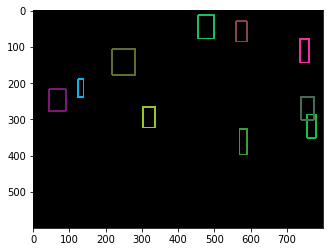

In [3]:
cols = 800
rows = 600
n_samples = 10

sim_box_list, img = simulate_data((cols, rows), n_samples)

## Analyze Bounding Boxes 

To analyze the data, we use the relative sizing of each pair of boxes to gain an estimate of the ratio between inter-box distance and average box height.

The steps, which are implemented in the function `count_undistanced` in `bounding_box.py`, are as follows:
1. Calculate $P$, the "depth similarity", between a pair of bounding boxes, by dividing the area of the smaller bounding box by the area of the larger bounding box. 
2. Calculate $D$, euclidean distance between the center of the two boxes.
3. Scale $D$ by the average bounding box height to gain $ID$, "inverse relative distance".
4. Multiply $ID$ by $P$ to get a ratio value that indicates distance. If this product is less than $(6/5.4)=1.11$, the people are not social distancing.
5. Return the count of number of people not socially distanced and their associated pair IDs, as well as the pairwise distance arrays, which gives the distances between pairs of boxes in pixel coordinates.

In [4]:
sim_box_list

[[107, 218, 178, 282],
 [267, 302, 323, 337],
 [30, 560, 86, 590],
 [13, 455, 78, 499],
 [327, 569, 397, 590],
 [287, 756, 352, 780],
 [79, 735, 144, 761],
 [190, 124, 240, 139],
 [238, 739, 302, 775],
 [218, 43, 278, 90]]

In [5]:
num_pairs, pair_ids, pairwise_distance_array = box.count_undistanced(sim_box_list)

print("Number of pairs of people not socially distanced:", num_pairs)
print("Pair IDs of those in violation of social distancing:\n", pair_ids)
print("Pairwise distance array:\n", pairwise_distance_array)

Number of pairs of people not socially distanced: 4
Pair IDs of those in violation of social distancing:
 [[0 7]
 [2 3]
 [5 8]
 [7 9]]
Pairwise distance array:
 [[  0.         167.59027418 335.80537518 246.85623346 395.91728934
  547.40569964 498.96392655 138.91904117 522.7860461  211.6660105 ]
 [167.59027418   0.         348.49569581 295.053385   268.49394779
  449.16867656 466.13785515 204.31348463 438.21370357 257.32858372]
 [335.80537518 348.49569581   0.          98.79397755 304.0333041
  325.00961524 181.08354426 470.46918071 279.40651388 542.83722238]
 [246.85623346 295.053385    98.79397755   0.         332.68378379
  399.69613458 278.92113581 384.83827772 358.8875172  457.72972375]
 [395.91728934 268.49394779 304.0333041  332.68378379   0.
  193.23172617 301.89816164 471.50079533 199.92561117 525.51403407]
 [547.40569964 449.16867656 325.00961524 399.69613458 193.23172617
    0.         208.95932619 645.02131748  50.70749452 705.13438436]
 [498.96392655 466.13785515 181.083544